In [1]:
# Cell 1: Imports and Global Definitions
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import spacy

# Load spaCy model (used for both training and prediction)
nlp = spacy.load("en_core_web_sm")

# Define the emoji pattern (used for cleaning text)
EMOJI_PATTERN = re.compile("["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F700-\U0001F77F"  # Alchemical symbols
    u"\U0001F780-\U0001F7FF"  # Geometric shapes
    u"\U0001F800-\U0001F8FF"  # Supplemental arrows
    u"\U0001F900-\U0001F9FF"  # Supplemental symbols
    u"\U0001FA00-\U0001FA6F"  # Chess symbols
    u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs
    u"\U00002702-\U000027B0"  # Dingbats
    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)


In [2]:
# Cell 2: Data Loading
df = pd.read_csv("flipkart.csv")
df = df[['review', 'sentiment']].dropna(subset=['review'])
df['sentiment'] = df['sentiment'].astype(str).str.strip()
print(f"Dataset loaded with {len(df)} rows")
df.head()

Dataset loaded with 28862 rows


,review,sentiment
0,Excellent 5g mobile phone in the budget range....,positive
1,Good mobile very good I have buy this mobile i...,neutral
2,Nice phone I totally satisfy with realme 2 Pro...,positive
3,Good and best ever real me series,positive
4,It's amazing especially for performance and th...,positive


In [3]:
# Cell 3: Define the Clean Text Function
def clean_text(text):
    """
    Clean the given text by removing emojis, URLs, punctuation, digits,
    converting to lowercase, lemmatizing, and removing stopwords using spaCy.
    """
    text = EMOJI_PATTERN.sub(r'', text)  # Remove emojis
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove digits
    doc = nlp(text)
    # Lemmatize and remove stopwords
    text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return text

In [4]:
# Cell 4: Preprocessing the Dataset
# Apply cleaning to the review text
df['review'] = df['review'].apply(clean_text)
print(f"Dataset size after advanced cleaning: {len(df)}")
print(df.head())

# Map sentiment strings to numeric values
valid_sentiments = {'positive': 0, 'neutral': 1, 'negative': 2}
print("Unique Sentiment Values Before Mapping:", df['sentiment'].unique())
df['sentiment'] = df['sentiment'].astype(str).str.lower().map(valid_sentiments)

# Drop any rows with missing review text and handle NaN sentiments
df = df[['review', 'sentiment']].dropna(subset=['review'])
print(f"Dataset size after dropping missing text: {df.shape[0]}")
missing_sentiments = df['sentiment'].isna().sum()
print(f"Rows with unrecognized sentiments: {missing_sentiments}")
df['sentiment'].fillna(1, inplace=True)  # Replace unrecognized sentiments with Neutral (1)
df['sentiment'] = df['sentiment'].astype(int)
print("Unique Sentiment Values After Encoding:", df['sentiment'].unique())


Dataset size after advanced cleaning: 28862
                                              review sentiment
0  excellent g mobile phone budget range camera g...  positive
1  good mobile good buy mobile   beautiful mobile...   neutral
2  nice phone totally satisfy realme   pro flipka...  positive
3                              good well real series  positive
4              amazing especially performance camera  positive
Unique Sentiment Values Before Mapping: ['positive' 'neutral' 'negative']
Dataset size after dropping missing text: 28862
Rows with unrecognized sentiments: 0
Unique Sentiment Values After Encoding: [0 1 2]


C:\Users\rewul\AppData\Local\Temp\ipykernel_11948\1565803667.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].fillna(1, inplace=True)  # Replace unrecognized sentiments with Neutral (1)


In [5]:
# Cell 5: Split Data and Prepare Doc2Vec Embeddings
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

# Doc2Vec parameters
doc2vec_vector_size = 200  # Increasing vector size for richer representations

# Prepare TaggedDocument objects for Doc2Vec (from training data)
tokenized_corpus = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]

# Train the Doc2Vec model
d2v_model = Doc2Vec(vector_size=doc2vec_vector_size, window=5, min_count=2, workers=4, epochs=20)
d2v_model.build_vocab(tokenized_corpus)
d2v_model.train(tokenized_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
d2v_model.save("doc2vec_model.model")  # Save for later prediction

# Define function to convert text to vector using Doc2Vec
def vectorize_text(text):
    return d2v_model.infer_vector(text.split(), epochs=50)

# Convert training and testing data into Doc2Vec vectors
X_train_vec = np.array([vectorize_text(text) for text in X_train])
X_test_vec = np.array([vectorize_text(text) for text in X_test])


In [6]:
# Cell 6: Reshape Vectors for LSTM and Handle Class Imbalance
time_steps = 10
feature_size = doc2vec_vector_size // time_steps  # This should be 200/10 = 20

# Make sure the Doc2Vec vector size is divisible by time_steps
if doc2vec_vector_size % time_steps != 0:
    raise ValueError(f"doc2vec_vector_size ({doc2vec_vector_size}) must be divisible by {time_steps}")

# Reshape vectors: new shape (samples, time_steps, feature_size)
X_train_vec = X_train_vec.reshape((X_train_vec.shape[0], time_steps, feature_size))
X_test_vec = X_test_vec.reshape((X_test_vec.shape[0], time_steps, feature_size))

In [8]:
# Cell 7: Build, Compile, and Train the Bi-LSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, feature_size)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

bilstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

bilstm_model.summary()

# Set up callbacks for early stopping and checkpointing the best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("bilstm_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = bilstm_model.fit(
    X_train_vec, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_vec, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 10, 256)             │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,379 (1.24 MB)

 Trainable params: 325,379 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8141 - loss: 0.5609
Epoch 1: val_loss improved from inf to 0.43023, saving model to bilstm_model.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.8141 - loss: 0.5607 - val_accuracy: 0.8607 - val_loss: 0.4302
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8564 - loss: 0.4365
Epoch 2: val_loss improved from 0.43023 to 0.41747, saving model to bilstm_model.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.8564 - loss: 0.4365 - val_accuracy: 0.8619 - val_loss: 0.4175
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8609 - loss: 0.4192
Epoch 3: val_loss improved from 0.41747 to 0.41235, saving model to bilstm_model.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8609 - loss: 0.4193 - val_accuracy: 0.8618 - val_loss: 0.4123
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8594 - loss: 0.4196
Epoch 4: val_loss improved from 0.

181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
Validation Accuracy: 0.87
Classification Report:

              precision    recall  f1-score   support

    Positive       0.89      0.98      0.93      4727
     Neutral       0.71      0.07      0.13       336
    Negative       0.71      0.58      0.64       710

    accuracy                           0.87      5773
   macro avg       0.77      0.54      0.57      5773
weighted avg       0.86      0.87      0.85      5773

Confusion Matrix:

[[4609    9  109]
 [ 251   24   61]
 [ 299    1  410]]


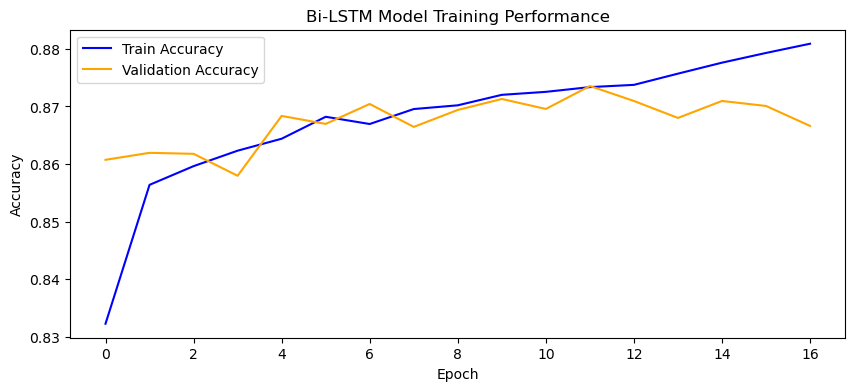

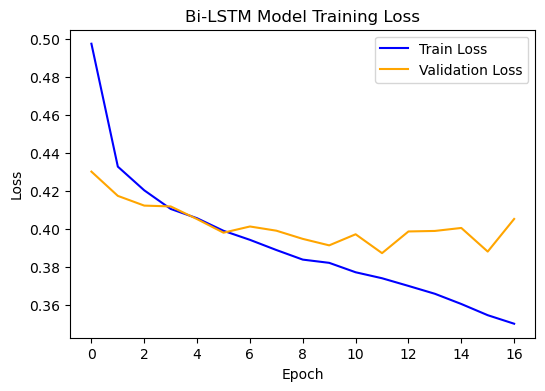

In [9]:
# Cell 8: Evaluate and Visualize Model Performance
y_pred = np.argmax(bilstm_model.predict(X_test_vec), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Positive', 'Neutral', 'Negative']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Plot Training vs. Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Bi-LSTM Model Training Performance')
plt.show()

# Plot Training vs. Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Bi-LSTM Model Training Loss')
plt.show()

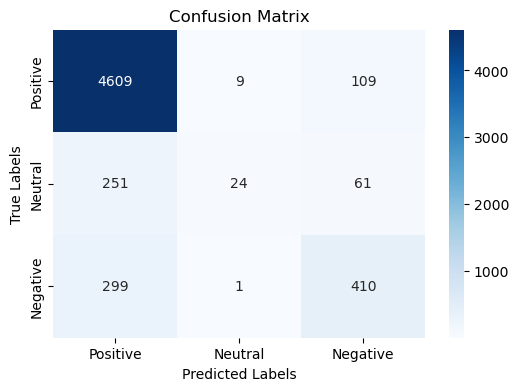

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Positive', 'Neutral', 'Negative']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

([<matplotlib.axis.XTick at 0x1c38d1c3200>,
 [Text(0, 0, 'Positive'), Text(1, 0, 'Neutral'), Text(2, 0, 'Negative')])

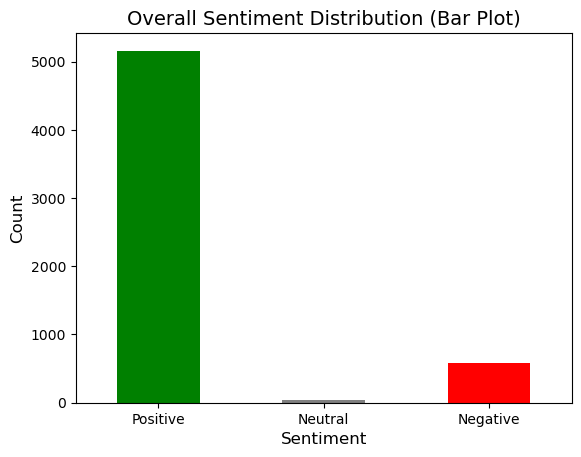

In [17]:
# Bar Plot
# Count of Predicted Labels
sentiment_counts = pd.Series(y_pred).value_counts().sort_index()

labels = ['Positive', 'Neutral', 'Negative']
colors = ['green', 'gray', 'red']
sentiment_counts.plot(kind='bar', color=colors)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Overall Sentiment Distribution (Bar Plot)', fontsize=14)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)